In [ ]:
!pip install transformers==4.5.0

In [2]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tensorflow.keras.utils import get_file
from PIL import Image
import numpy as np

from transformers import get_linear_schedule_with_warmup

In [3]:
epochs = 300
batch_size_train = 32
batch_size_test = 512

myseed = 29
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [ ]:
# Download cats and dogs dataset
URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = get_file('/content/cats_and_dogs.zip', origin=URL, extract=True)
!unzip '/content/cats_and_dogs.zip'

train_path = '/content/cats_and_dogs_filtered/train'
test_path = '/content/cats_and_dogs_filtered/validation'

(500, 374)


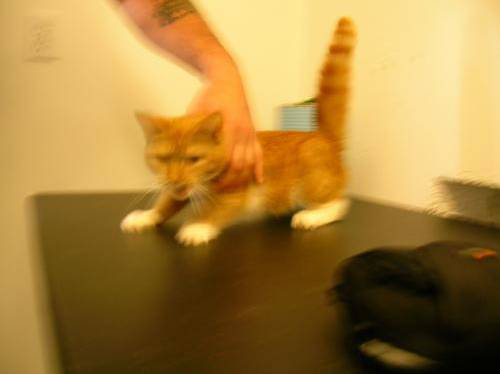

In [5]:
# Show image
img = Image.open('/content/cats_and_dogs_filtered/train/cats/cat.0.jpg')
print(img.size)
display(img)

In [6]:
train_transforms = transforms.Compose([transforms.Resize((256,256)),
                    transforms.RandomChoice(
                        [transforms.AutoAugment(),
                        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
                        transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
                        transforms.AutoAugment(transforms.AutoAugmentPolicy.SVHN)]
                    ),
                    transforms.RandomAdjustSharpness(2, p=0.5),
                    transforms.RandomAutocontrast(p=0.5),
                    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                    transforms.RandomEqualize(p=0.5),            
                    transforms.RandomAffine(degrees=15, shear=(0,15)),
                    transforms.RandomGrayscale(p=0.5),
                    transforms.PILToTensor(),
                    transforms.RandomErasing(p=0.5)])

train_flip_transforms = transforms.Compose([transforms.Resize((256,256)),
                    transforms.RandomChoice(
                        [transforms.AutoAugment(),
                        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
                        transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
                        transforms.AutoAugment(transforms.AutoAugmentPolicy.SVHN)]
                    ),
                    transforms.RandomAdjustSharpness(2, p=0.5),
                    transforms.RandomAutocontrast(p=0.5),
                    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                    transforms.RandomEqualize(p=0.5),            
                    transforms.RandomHorizontalFlip(p=1),
                    transforms.RandomAffine(degrees=15, shear=(0,15)),
                    transforms.RandomGrayscale(p=0.5),
                    transforms.PILToTensor(),
                    transforms.RandomErasing(p=0.5)])

test_transforms = transforms.Compose([transforms.Resize((256,256)),
                    transforms.PILToTensor()])

In [7]:
train_data = datasets.ImageFolder(train_path, transform=train_transforms)
train_flip_data = datasets.ImageFolder(train_path, transform=train_flip_transforms)
train_data = torch.utils.data.ConcatDataset([train_data, train_flip_data])

test_data = datasets.ImageFolder(test_path, transform=test_transforms)

In [8]:
print(test_data.class_to_idx)

{'cats': 0, 'dogs': 1}


In [9]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_train, shuffle=True, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test, shuffle=False, pin_memory=True)

In [10]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [11]:
example_data.shape

torch.Size([512, 3, 256, 256])

In [12]:
def get_label(label):
  if label == 0:
    return "Cat"
  return "Dog"

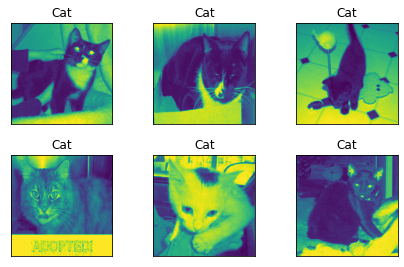

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0])
  plt.title("{}".format(get_label(example_targets[i])))
  plt.xticks([])
  plt.yticks([])

In [14]:
[list(test_data.class_to_idx.values()).index(0)]

[0]

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(0.2)

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout4 = nn.Dropout(0.2)

        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.dropout5 = nn.Dropout(0.2)

        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1)
        self.bn6 = nn.BatchNorm2d(1024)
        self.dropout6 = nn.Dropout(0.2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1024, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.dropout2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.dropout3(x)
        x = F.relu(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.dropout4(x)
        x = F.relu(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = self.dropout5(x)
        x = F.relu(x)

        x = self.conv6(x)
        x = self.bn6(x)
        x = self.dropout6(x)
        x = F.relu(x)

        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return torch.sigmoid(x)

In [16]:
# Warm up
warm_up_ratio = 0.1
step = len(train_loader)
total_step = epochs * step

network = Net()
network.cuda()
optimizer = torch.optim.RAdam(network.parameters(), lr=1e-3, weight_decay=5e-4)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = warm_up_ratio * total_step, num_training_steps = total_step)

In [17]:
train_losses = []
train_counter = []
test_accuracy = []
test_losses = []

best_epoch = 0
best_loss = np.inf

In [18]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.cuda(), target.cuda()
    optimizer.zero_grad()
    pred = network(data.float())
    loss = F.binary_cross_entropy(pred.view(-1), target.float())
    loss.backward()
    optimizer.step()
    scheduler.step()

  train_losses.append(loss.item())
  train_counter.append(epoch)

In [19]:
def test(epoch):
  global best_epoch, best_loss

  loss = 0
  correct = 0
  network.eval()
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.cuda(), target.cuda()
      pred = network(data.float())
      pred = pred.view(-1)
      loss += F.binary_cross_entropy(pred, target.float(), reduction='sum').item()
      pred = torch.where(pred > 0.5, 1, 0)
      correct += torch.where(pred == target, 1, 0).sum()

  loss /= len(test_loader.dataset)

  if best_loss > loss:
    best_epoch, best_loss = epoch, loss
    torch.save(network.state_dict(), '/content/model.pth')
    torch.save(optimizer.state_dict(), '/content/optimizer.pth')
    print('Saving model (epoch = {:1d}, Loss = {:.4f}, Accuracy = {:.1f}%)'.format(epoch, loss, (100*correct/len(test_loader.dataset))))

  test_losses.append(loss)
  test_accuracy.append((100 * correct / len(test_loader.dataset)).item())
  return best_epoch, best_loss

In [20]:
for epoch in range(1, epochs+1):
  train(epoch)
  test(epoch)

Saving model (epoch = 1, Loss = 0.7509, Accuracy = 50.0%)
Saving model (epoch = 2, Loss = 0.7025, Accuracy = 52.2%)
Saving model (epoch = 4, Loss = 0.6885, Accuracy = 60.4%)
Saving model (epoch = 5, Loss = 0.6837, Accuracy = 56.9%)
Saving model (epoch = 7, Loss = 0.6449, Accuracy = 60.9%)
Saving model (epoch = 8, Loss = 0.6409, Accuracy = 61.0%)
Saving model (epoch = 10, Loss = 0.5997, Accuracy = 66.8%)
Saving model (epoch = 18, Loss = 0.5767, Accuracy = 69.5%)
Saving model (epoch = 20, Loss = 0.5616, Accuracy = 71.4%)
Saving model (epoch = 22, Loss = 0.5556, Accuracy = 72.5%)
Saving model (epoch = 28, Loss = 0.5513, Accuracy = 71.8%)
Saving model (epoch = 42, Loss = 0.5097, Accuracy = 75.8%)
Saving model (epoch = 45, Loss = 0.4984, Accuracy = 76.2%)
Saving model (epoch = 46, Loss = 0.4954, Accuracy = 77.4%)
Saving model (epoch = 48, Loss = 0.4790, Accuracy = 77.6%)
Saving model (epoch = 52, Loss = 0.4615, Accuracy = 79.9%)
Saving model (epoch = 54, Loss = 0.4443, Accuracy = 78.8%)
Sav

Text(0, 0.5, 'Loss')

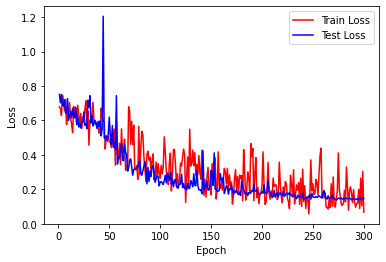

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(train_counter, train_losses, color='red')
plt.plot(train_counter, test_losses, color='blue')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

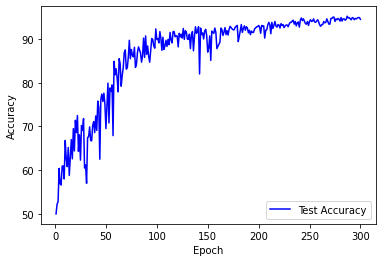

In [22]:
fig = plt.figure()
plt.plot(train_counter, test_accuracy, color='blue')
plt.legend(['Test Accuracy'], loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

#Predict

In [23]:
best_network = Net()
network_state_dict = torch.load('/content/model.pth')
best_network.load_state_dict(network_state_dict)

<All keys matched successfully>

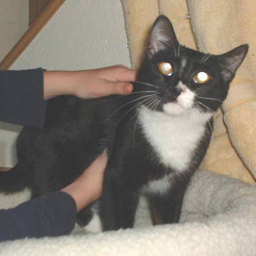

In [24]:
img = Image.open('/content/cats_and_dogs_filtered/validation/cats/cat.2000.jpg').resize((256, 256))
display(img)

In [25]:
transform = transforms.ToTensor()
input = transform(img)
input = torch.unsqueeze(input, 0)

In [26]:
best_network.eval()
output = best_network(input)

Cat


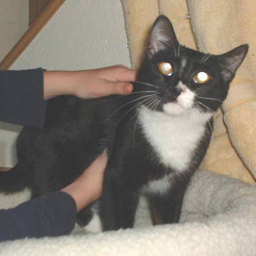

In [27]:
if output.item() < 0.5: # 0:Cat, 1:Dog 
  print("Cat")
else:
  print("Dog")

display(img)